<a href="https://colab.research.google.com/github/bikash119/bikash119/blob/main/learn_pytorch_08.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

##ViT paper implementation steps

In [3]:
## Calculate the patch embeddings input and output shape
height = 224 # H
width = 224 # W
color_channels = 3 # C
patch_size= 16 # P

## Calculate N ( number of patches)
number_of_patches = int((height * width) / (patch_size**2))
print(f"Number of patches (N) with image height (H={height}, width={width}) and patch size (P =  {patch_size}) : {number_of_patches}")

Number of patches (N) with image height (H=224, width=224) and patch size (P =  16) : 196


### As mentioned in section 3.1 of ViT paper, the image of shape ( H, W,C ) will have to be converted to shape (number_of_patches, patch_size**2 * C)

In [5]:
## Input Shape ( Shape of single image)
embedding_layer_input_shape = (height, width, color_channels)
## Output Shape
embedding_layer_output_shape = (number_of_patches, patch_size**2*color_channels)

print(f'Input shape (single 2D image) : {embedding_layer_input_shape}')
print(f'Output shape (single 2D image flattened into patches) : {embedding_layer_output_shape}')

Input shape (single 2D image) : (224, 224, 3)
Output shape (single 2D image flattened into patches) : (196, 768)


## Download the data

In [6]:
import os
import zipfile

from pathlib import Path
import requests

def download_data(source:str,
                  destination:str,
                  remove_zip:bool=False) -> Path:
  """
    Downloads a zipped dataset and unzips it at destination

    Args:
      source(string): A link to zipped dataset
      destination(string): A target directory to unizp the downloaded zip file
      remove_zip(boolean): Whether to remove the source zip file after extracting.

    Returns:
      pathlib.Path to downloaded data.

    Example_Usage :
      download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                    destination="pizza_steak_sushi")
  """

  data_path = Path('data/')
  img_path = data_path / destination

  if img_path.is_dir():
    print(f"[INFO] {img_path} exists. Skipping download.")
  else:
    print(f"[INFO] Couldn't find {img_path} directory, creating one.")
    img_path.mkdir(parents=True,exist_ok=True)

    # Download data
    target_file = Path(source).name
    with open(data_path/target_file,"wb") as f:
      request = requests.get(source)
      f.write(request.content)

    #Unzip the downloaded data
    with zipfile.ZipFile(data_path/target_file,'r') as zipref:
      print(f"Unzipping {target_file} file to {destination}")
      zipref.extractall(img_path)

  if remove_zip:
    os.remove(data_path / target_file)

  return img_path


image_path = download_data(source="https://github.com/mrdbourke/pytorch-deep-learning/raw/main/data/pizza_steak_sushi.zip",
                           destination="pizza_steak_sushi")
image_path

[INFO] Couldn't find data/pizza_steak_sushi directory, creating one.
Unzipping pizza_steak_sushi.zip file to pizza_steak_sushi


PosixPath('data/pizza_steak_sushi')

In [9]:
try:
  from learn_pytorch.classification_src import data_setup, engine
except:
  !rm -r learn-pytorch
  !git clone https://github.com/bikash119/learn-pytorch.git
  !mv learn-pytorch learn_pytorch
  from learn_pytorch.classification_src import data_setup, engine

In [10]:
import torch
import torchvision
from torchvision import transforms
IMAGE_SIZE = 224 ## As mandated in the ViT paper
train_dir = image_path / "train"
test_dir = image_path / "test"

## Create transforms
manual_transforms = transforms.Compose([
    transforms.Resize((IMAGE_SIZE,IMAGE_SIZE)),
    transforms.ToTensor()
])

train_dataloader, test_dataloader, classes = data_setup.create_dataloader(train_dir=train_dir,
                                                                          test_dir=test_dir,
                                                                          train_transforms=manual_transforms,
                                                                          test_transforms=manual_transforms,
                                                                          batch_size=32)

train_dataloader, test_dataloader, classes

(<torch.utils.data.dataloader.DataLoader at 0x7fe324bff040>,
 ['pizza', 'steak', 'sushi'])

 Shape of single image :torch.Size([3, 224, 224])
 Label of the image : pizza


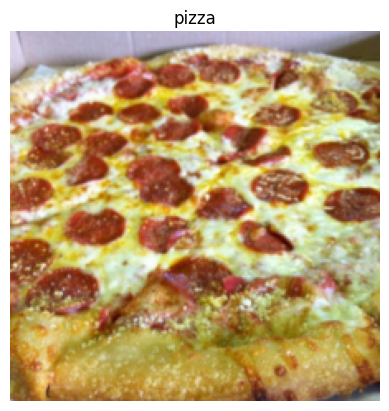

In [18]:
## Visualize the single image
image_batch,label_batch = next(iter(train_dataloader))
single_image, label = image_batch[0], label_batch[0]
print(f" Shape of single image :{single_image.shape}")
print(f" Label of the image : {classes[label]}" )
## Use matplotlib to display the image
import matplotlib.pyplot as plt

plt.imshow(single_image.permute(1,2,0))
plt.title(classes[label])
plt.axis(False);


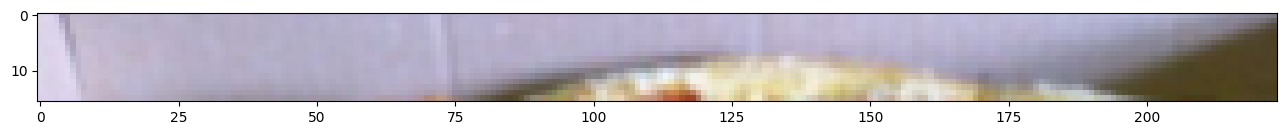

In [23]:
## Convert the image into patches
patch_size = 16
plt.figure(figsize=(patch_size,patch_size))
plt.imshow(single_image.permute(1,2,0)[:patch_size,:,:]);

 Number of patches per row :14.0 
 Patch size: 16 pixels x 16 pixels


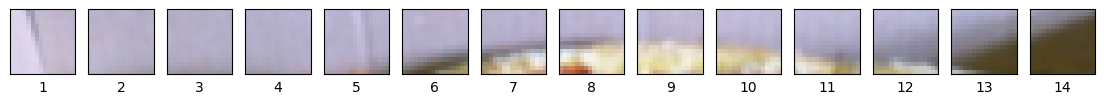

In [24]:
## Create patches out of the first row
## Setup hyperparameters and make sure `image_size` is compatible with `patch_size`
image_size=224
patch_size=16
permuted_image = single_image.permute(1,2,0)
num_patches= image_size/patch_size
assert image_size % patch_size == 0, "image_size must be divisible by patch_size"
print(f" Number of patches per row :{ num_patches} \n Patch size: {patch_size} pixels x {patch_size} pixels")

#Create a series of subplots
fig,axs = plt.subplots(nrows=1,
                       ncols=image_size//patch_size,
                       figsize=(num_patches,num_patches),
                       sharex=True,
                       sharey=True)

for i,patch in enumerate(range(0,image_size,patch_size)):
  axs[i].imshow(permuted_image[:patch_size,patch:patch_size+patch,:])
  axs[i].set_xlabel(i+1)
  axs[i].set_xticks([])
  axs[i].set_yticks([])



 Number of patches per row :14.0 
 Patch size: 16 pixels x 16 pixels


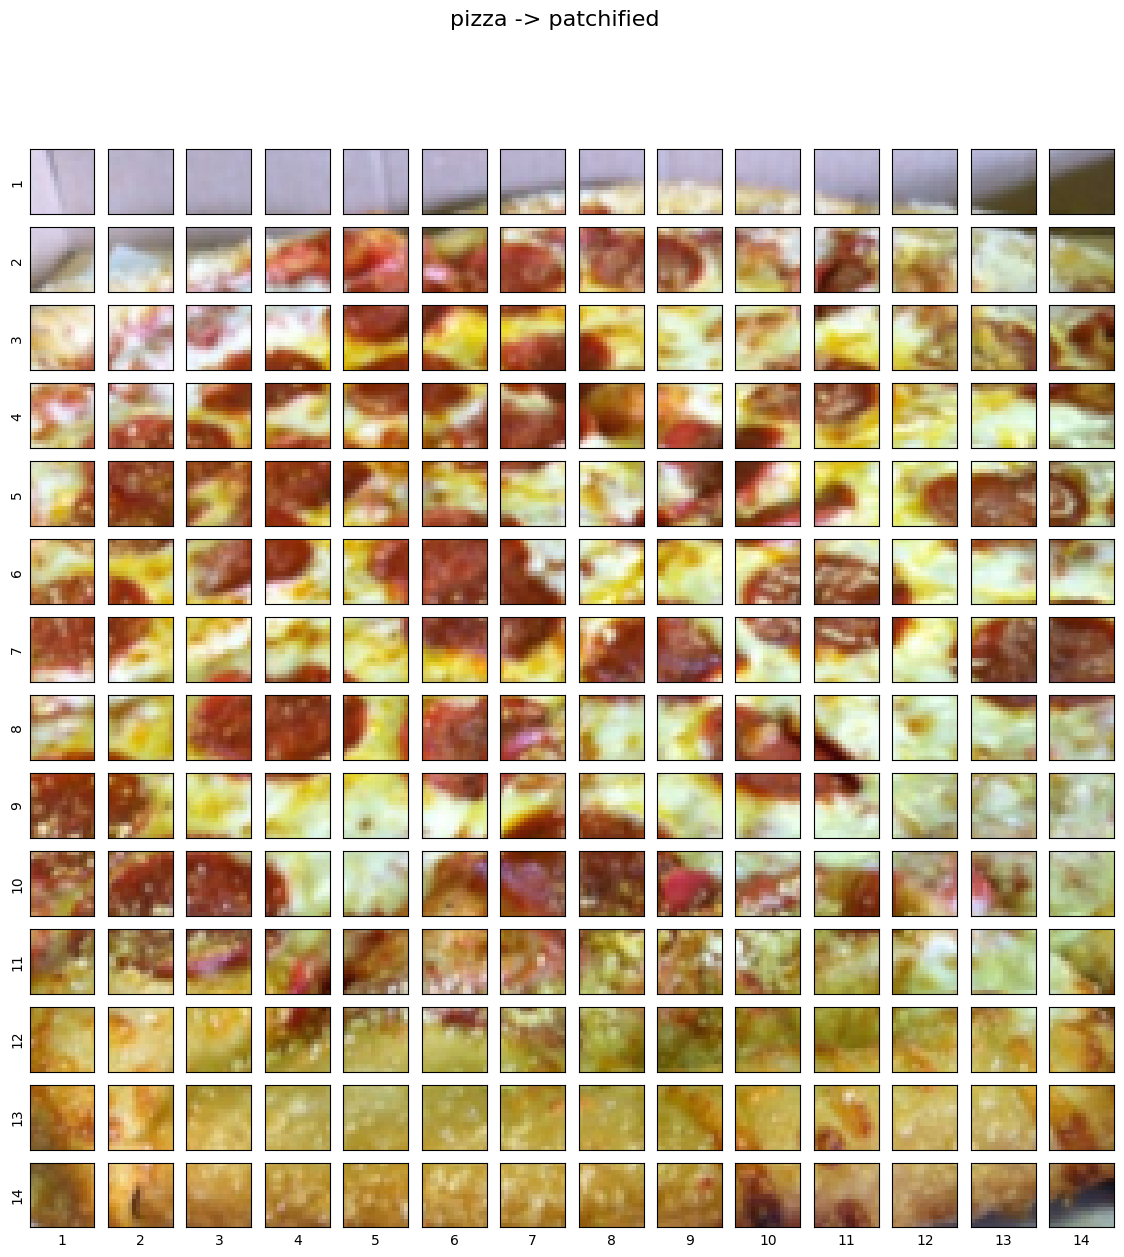

In [26]:
## Create patches for entire image
## Setup hyperparameters and make sure `image_size` is compatible with `patch_size`
image_size=224
patch_size=16
permuted_image = single_image.permute(1,2,0)
num_patches= image_size/patch_size
assert image_size % patch_size == 0, "image_size must be divisible by patch_size"
print(f" Number of patches per row :{ num_patches} \n Patch size: {patch_size} pixels x {patch_size} pixels")

#Create a series of subplots
fig,axs = plt.subplots(nrows=image_size//patch_size,
                       ncols=image_size//patch_size,
                       figsize=(num_patches,num_patches),
                       sharex=True,
                       sharey=True)

for i,patch_height in enumerate(range(0,image_size,patch_size)):
  for j,patch_width in enumerate(range(0,image_size,patch_size)):
    axs[i,j].imshow(permuted_image[patch_height:patch_size+patch_height,
                                   patch_width:patch_size+patch_width,
                                   :])
    axs[i,j].set_xlabel(j+1)
    axs[i,j].set_ylabel(i+1)
    axs[i,j].set_yticks([])
    axs[i,j].set_xticks([])
    axs[i,j].label_outer()

fig.suptitle(f"{classes[label]} -> patchified",fontsize=16)
plt.show()

### Replicate the patch embedding layers with PyTorch
> **Hybrid Architecture**. As an alternative to raw image patches, the input sequence can be formed
from feature maps of a CNN (LeCun et al., 1989). In this hybrid model, the patch embedding
projection E (Eq. 1) is applied to patches extracted from a **CNN feature map**. As a special case,
the patches can have spatial size 1x1, which means that the input sequence is obtained by simply
flattening the spatial dimensions of the feature map and projecting to the Transformer dimension.
The classification input embedding and position embeddings are added as described above.

*The CNN feature map referred above are the weights/activations produced by convolutional layer passing over an image*

##### Re-create the creation of patches in pytorch by setting the `kernel_size` and `stride` equal to `patch_size` in `torch.nn.Conv2d`

In [28]:
from torch import nn

#Set the patch size
patch_size = 16

conv2d = nn.Conv2d(in_channels=3,
                   out_channels=768,
                   kernel_size=patch_size,
                   stride=patch_size,
                   padding=0)

## image out of conv layer
conv_output = conv2d(single_image.unsqueeze(dim=0))
print(f"Shape of conv_output : {conv_output.shape} -> [batch_size,embedding_dim, feature_map_height,feature_map_width]")

Shape of conv_output : torch.Size([1, 768, 14, 14]) -> [batch_size,embedding_dim, feature_map_height,feature_map_width]


 Showing random convolutional feature maps from indexes :[130, 435, 765, 529, 149]


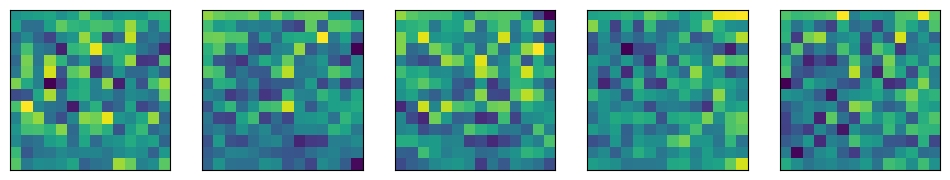

In [29]:
## Plot random 5 convolutional feature maps
import random
random_indexes = random.sample(range(0,786),k=5)

print(f" Showing random convolutional feature maps from indexes :{random_indexes}")

# Create plot
fig, axs = plt.subplots(nrows=1,ncols=5,figsize=(12,12))

for i, idx in enumerate(random_indexes):
  img_conf_feature_map=conv_output[:,idx,:,:]
  axs[i].imshow(img_conf_feature_map.squeeze().detach().numpy())
  axs[i].set(xticklabels=[],yticklabels=[],xticks=[],yticks=[]);

In [31]:
!whoami

root


In [33]:
single_feature_map=conv_output[:,0,:,:]
single_feature_map,single_feature_map.requires_grad

(tensor([[[-0.5488, -0.5016, -0.5063, -0.5169, -0.5266, -0.5920, -0.5746,
           -0.4359, -0.4762, -0.5738, -0.6122, -0.5648, -0.6009, -0.3847],
          [-0.5854, -0.2436, -0.2158, -0.3386, -0.2571, -0.2852, -0.3731,
           -0.2442, -0.1536, -0.5049, -0.5016, -0.6572, -0.4395, -0.2877],
          [-0.4883, -0.5472, -0.3296, -0.6958, -0.1536, -0.1759, -0.4225,
           -0.4370, -0.4397, -0.3090, -0.6466, -0.4681, -0.4691, -0.3100],
          [-0.3373, -0.6755, -0.2440, -0.1760,  0.0080, -0.1574, -0.3408,
           -0.2470, -0.6107, -0.2978, -0.1865, -0.2564, -0.1240,  0.0918],
          [-0.4975, -0.2530, -0.1123, -0.1323, -0.0566, -0.3011, -0.4557,
           -0.2376, -0.3926, -0.3402, -0.3204, -0.4602, -0.1951, -0.2762],
          [-0.5167, -0.3583, -0.3113, -0.1098, -0.1276, -0.2071, -0.6106,
           -0.5237, -0.2108, -0.6364, -0.5122, -0.6212, -0.2960, -0.1320],
          [-0.1356, -0.0329, -0.4875, -0.3312, -0.3689, -0.0158, -0.0170,
           -0.3732, -0.3652, -0.

## Flattening the patch embedding with `torch.nn.Flatten()`
**Desired output (1D sequence of flattend 2D patches):** (196,768) -> (Number of patches, embedding dimension) -> N X (P<sup>2</sup>.C)

In [34]:
#current tensor shape
print(f" Current tensor shape : {conv_output.shape}")

 Current tensor shape : torch.Size([1, 768, 14, 14])


We have the P<sup>2</sup>.C piece from -> N X (P<sup>2</sup>.C).We can use the `nn.Flatten()` to flatten the _spatial feature map_ as mentioned in **Hybrid Architecture** section of ViT paper

In [36]:
flatten = nn.Flatten(start_dim=2,end_dim=3)

### Lets put everything together

1. Take a single image
2. Put it through the convolution layer `nn.Conv2d` to turn the image into 2D feature maps (patch embeddings)
3. Flatten the 2D feature maps to a single sequence





 Shape of original image : torch.Size([3, 224, 224])
 Shape of output of conv2d : torch.Size([1, 768, 14, 14])
 Shape of flattened output : torch.Size([1, 768, 196])


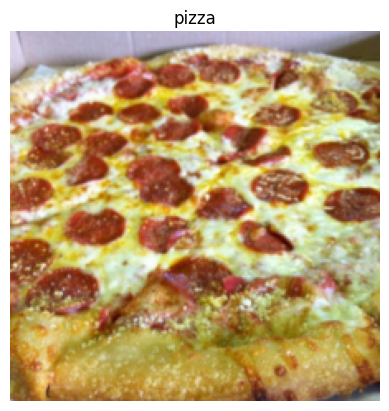

In [42]:
plt.imshow(single_image.permute(1,2,0))
plt.title(classes[label])
plt.axis(False);
print(f" Shape of original image : {single_image.shape}")

img_out_of_conv = conv2d(single_image.unsqueeze(dim=0))
print(f" Shape of output of conv2d : {img_out_of_conv.shape}")
flattened_image = flatten(img_out_of_conv)
print(f" Shape of flattened output : {flattened_image.shape}")

## Almost there
**Desired output** : (196, 768)

**Flattened output** : (1, 768, 196)

We can use `torch.Tensor.permute` to bring the output of `nn.Flatten()` to the desired output

In [44]:
conv_output_flattened_reshaped = flattened_image.permute(0,2,1)
print(f" Shape of the reshaped tensor after passing through conv2d and flatten : {conv_output_flattened_reshaped.shape} -> [ batch_size,number_of_patches,embedding_dim ]")

 Shape of the reshaped tensor after passing through conv2d and flatten : torch.Size([1, 196, 768]) -> [ batch_size,number_of_patches,embedding_dim ]


## Visualize a single feature map

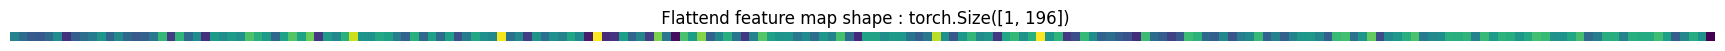

In [47]:
single_flattened_feature_map = conv_output_flattened_reshaped[:,:,1]

plt.figure(figsize=(22,22))
plt.imshow(single_flattened_feature_map.detach().numpy())
plt.title(f" Flattend feature map shape : {single_flattened_feature_map.shape}")
plt.axis(False);

### Turing the ViT patch embedding layer into a Pytorch module


1. Create a class called `PatchEmbedding` with subclasses `nn.Module`
2. Initialize the class with parameters `in_channels=3, patch_size=16 and embedding_dim=768`
3. Create a layer to turn images into patches using `nn.Conv2d`.
4. Flatten the output of step 3. using `nn.Flatten` and flatten only the _patch feature maps_ into a single dimension.
5. Define a `forward()` method to take the input and pass it through the layers created in Step 3. and Step 4.
6. Make sure the output shape reflects the required output shape of the ViT architecture ( N X P<sup>2</sup>.C)



In [60]:
class PatchEmbedding(nn.Module):

  """
    Turns a 2D input image into a 1D sequence learnable embedding vector

    Args:
      in_channels(integer): Number of color channels for the input images. Defaults to 3
      patch_size(integer): Size of patches to convert the image into. Defults to 16
      embedding_dim(integer): Size of embedding to turn image into. Defaults to 768
  """
  def __init__(self, in_channels:int= 3,
               patch_size:int= 16,
               embedding_dim:int= 768):
    super().__init__()

    ## The layer to convert image to patches
    self.patcher = nn.Conv2d(in_channels=in_channels,
                             out_channels=embedding_dim,
                             kernel_size=patch_size,
                             stride=patch_size,
                             padding=0)

    ## The layer to flatten the patch feature maps into a single dimension
    self.flatten = nn.Flatten(start_dim=2,
                              end_dim=3)

  def forward(self,x):
    image_resolution=x.shape[-1]
    assert image_resolution % patch_size ==0 ,f"Input size must be divisible by patch_size, image_shape: {image_resolution}, patch_size:{patch_size}"

    # perform the forward pass
    x_patched = self.patcher(x)
    #print(f" Shape of patched image : {x_patched.shape}")
    x_flattend = self.flatten(x_patched)
    #print(f" Shape of flattend output : {x_flattend.shape}")
    return x_flattend.permute(0,2,1)



Lets try the `PatchEmbedding` on a single image

In [63]:
patchify = PatchEmbedding(in_channels=3,
                          patch_size=16,
                          embedding_dim=768)

print(f" Shape of single image : {single_image.shape}")
## Pass the image through patch embedding
patched_flattend_img = patchify(single_image.unsqueeze(dim=0))
print(f" Shape of image after going through PatchEmbedding: {patched_flattend_img.shape}")

 Shape of single image : torch.Size([3, 224, 224])
 Shape of patched image : torch.Size([1, 768, 14, 14])
 Shape of flattend output : torch.Size([1, 768, 196])
 Shape of image after going through PatchEmbedding: torch.Size([1, 196, 768])
